<a href="https://colab.research.google.com/github/prateem-biswas/Molecular-Solubility-prediction/blob/main/Predicting_solubity_of_molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cheminformatics Project - Predicting Solubility of Molecules**


The solubility of drugs is an important property in Drug discovery, design and development . The aim of this project is to apply machine learning for predicting the solubility of various molecules.

This idea for this notebook was inspired by the excellent blog post by Pat Walters  where he reproduced the linear regression model with similar degree of performance as that of Delaney.

##Installing rdkit

In [83]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-08-20 20:01:54--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   146MB/s    in 0.6s    

2022-08-20 20:01:54 (146 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ | / - \ | / - \ 

## **Delaney's solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/10.1021/ci034243x) available as a [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x). The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).

# **Downloading Dataset**

In [84]:
import pandas as pd

In [85]:
url = "https://raw.githubusercontent.com/prateem-biswas/Data-Science-/main/solubility.csv"
df = pd.read_csv(url)

#**Exploring the dataset**

In [86]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


The second column, **measured log(solubility:mol/L)** contains the actual solubility values of the molecules, while the third column **ESOL predicted log(solubility:mol/L)** gives the solubility values obtained by Delany.

In [87]:
df.columns

Index(['Compound ID', 'measured log(solubility:mol/L)',
       'ESOL predicted log(solubility:mol/L)', 'SMILES'],
      dtype='object')

In [88]:
df.describe()

,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L)
count,1144.000000,1144.000000
mean,-3.057997,-2.994776
std,2.096502,1.686520
min,-11.600000,-9.702000
25%,-4.332250,-3.962250
50%,-2.870500,-2.889000
75%,-1.600000,-1.846750
max,1.580000,1.091000


# Examining the SMILES column

The **simplified molecular-input line-entry system** **(SMILES)** is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. SMILES strings can be imported by most molecule editors for conversion back into two-dimensional drawings or three-dimensional models of the molecules.

The SMILES column in the dataset consists of the list of all the notations of the molecules in the SMILES format

In [89]:
df[['SMILES']].head(5)

,SMILES
0,ClCC(Cl)(Cl)Cl
1,CC(Cl)(Cl)Cl
2,ClC(Cl)C(Cl)Cl
3,ClCC(Cl)Cl
4,FC(F)(Cl)C(F)(Cl)Cl


#**Calculate Molecular Descriptors in rdkit**

Molecular descriptors can be defined as mathematical representations of molecules' properties that are generated by algorithms. The numerical values of molecular descriptors are used to quantitatively describe the physical and chemical information of the molecules. For calculating the SMILES data needs to be converted to rdkit object

###**Convert list of molecules from SMILES notation to rdkit object**

In [90]:
from rdkit import Chem

In [91]:
mol_list= []
for element in df.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [92]:
mol_list[:10]

In [93]:
len(mol_list)

1144

###**Calculating molecular descriptors**

To predict LogS (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:


1.   **cLogP** (Octanol-water partition coefficient)
2.   **MW** (Molecular weight)
3.   **RB** (Number of rotatable bonds)
4.    **AP** (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)

rdkit has functions to compute the first 3 descritors. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.


In [94]:
from rdkit.Chem import Descriptors

In [95]:
moldata= []
for element in df.SMILES:
  mol=Chem.MolFromSmiles(element) 
  moldata.append(mol)

desc_MolLogP = []
desc_MolWt = []
desc_Rotatable_Bonds = []

for mol in moldata :
  desc_MolLogP.append(Descriptors.MolLogP(mol))
  desc_MolWt.append(Descriptors.MolWt(mol))
  desc_Rotatable_Bonds.append(Descriptors.NumRotatableBonds(mol))


table = {"MolLogP" : desc_MolLogP , "MolWt" : desc_MolWt , "RotatableBonds": desc_Rotatable_Bonds}

descriptors = pd.DataFrame(table)
    

In [96]:
descriptors.head()

,MolLogP,MolWt,RotatableBonds
0,2.5954,167.850,0
1,2.3765,133.405,0
2,2.5938,167.850,1
3,2.0289,133.405,1
4,2.9189,187.375,1


In [97]:
len(descriptors.index)

1144

##**Aromatic Proportion**

It is simply the ratio of the number of aromatic atoms to that of the total number of heavy atoms. To get the aromatic proportion, we first need to get the data for the number of aromatic atoms and number of heavy atoms for each molecule.

### Number of Aromatic Atoms

The number of aromatic atoms determines the total number of atoms in a molecule that constitute to its aromaticity

**Calculating Number of Aromatic Atoms for a single molecule**

In [98]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
aromatic_atoms = []
for i in range (m.GetNumAtoms()):
  aromatic_atoms.append(m.GetAtomWithIdx(i).GetIsAromatic())

In [99]:
aromatic_atoms[:10]

[False, False, True, True, True, True, True, True, True, False]

This gives us a list consisting of boolean values. To get the numerical value , we use the sum function. This returns counts all the positions where the value is True.

In [100]:
print(sum(aromatic_atoms))

19


**Calculating Number of Aromatic Atoms for the complete Dataset**

In [101]:
def NumAromaticAtom(m):
  aromatic_atoms = []
  for i in range (m.GetNumAtoms()):
    aromatic_atoms.append(m.GetAtomWithIdx(i).GetIsAromatic())

  return sum(aromatic_atoms)
  

In [102]:
Desc_AromaticAtoms = []
for element in moldata :
  Desc_AromaticAtoms.append(NumAromaticAtom(element))

In [103]:
Desc_AromaticAtoms[:20] #The number of aromatic atoms for the first 20 molecules

[0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [104]:
len(Desc_AromaticAtoms)

1144

**Calculating the Number of Heavy Atoms**

Heavy atom refers to any atom that is not hydrogen. Here, we will use an existing function for calculating the Number of heavy atoms.

**Computing for a single molecule.**

In [105]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

**Calculating Number of Heavy Atoms for the complete Dataset**

In [106]:
desc_HeavyAtomCount = []
for element in moldata :
  desc_HeavyAtomCount.append(Descriptors.HeavyAtomCount(element))

In [107]:
desc_HeavyAtomCount[:20] #The number of Heavy atoms for the first 20 molecules

[6, 5, 6, 5, 8, 4, 4, 8, 10, 10, 10, 9, 9, 10, 10, 10, 9, 9, 9, 8]

In [108]:
len(desc_HeavyAtomCount)

1144

###**Computing the Aromatic Proportion (AP) descriptor**

In [109]:
desc_AromaticProportion = [i / j for i, j in zip(Desc_AromaticAtoms, desc_HeavyAtomCount)]

In [110]:
desc_AromaticProportion[:20]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75]

In [111]:
len(desc_AromaticProportion)

1144

In [112]:
df_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


##**Combining all computed descriptors into 1 dataframe   (X Matrix)**






In [113]:
descriptors

,MolLogP,MolWt,RotatableBonds
0,2.59540,167.850,0
1,2.37650,133.405,0
2,2.59380,167.850,1
3,2.02890,133.405,1
4,2.91890,187.375,1
...,...,...,...
1139,1.98820,287.343,8
1140,3.42130,286.114,2
1141,3.60960,308.333,4
1142,2.56214,354.815,3


In [114]:
df_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


In [115]:
X = pd.concat([descriptors,df_AromaticProportion], axis=1)

In [116]:
X

,MolLogP,MolWt,RotatableBonds,AromaticProportion
0,2.59540,167.850,0,0.000000
1,2.37650,133.405,0,0.000000
2,2.59380,167.850,1,0.000000
3,2.02890,133.405,1,0.000000
4,2.91890,187.375,1,0.000000
...,...,...,...,...
1139,1.98820,287.343,8,0.000000
1140,3.42130,286.114,2,0.333333
1141,3.60960,308.333,4,0.695652
1142,2.56214,354.815,3,0.521739


##**Solubility Data (Y Matrix)**

In [117]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


The second column, ie, the measured solubility data is taken as the feature


In [118]:
Y = df.iloc[:,1]

In [119]:
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

##**Splitting data for Training and Testing**

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [141]:
X_train

,MolLogP,MolWt,RotatableBonds,AromaticProportion
643,3.61260,296.410,0,0.272727
722,6.48760,226.448,13,0.000000
570,3.15380,284.746,1,0.600000
66,0.77880,74.123,2,0.000000
1002,1.82140,102.177,3,0.000000
...,...,...,...,...
1044,2.82960,253.305,1,0.631579
1095,2.10750,218.322,3,0.000000
1130,4.14820,335.282,7,0.260870
860,4.25720,275.179,4,0.352941


In [142]:
Y_train

643    -4.300
722    -8.400
570    -3.754
66      0.000
1002   -1.340
        ...  
1044   -3.324
1095   -1.620
1130   -5.680
860    -4.770
1126   -6.010
Name: measured log(solubility:mol/L), Length: 915, dtype: float64

In [143]:
X_test

,MolLogP,MolWt,RotatableBonds,AromaticProportion
218,1.55740,102.177,3,0.000000
809,5.20590,345.653,4,0.571429
501,4.18090,339.218,4,0.545455
649,2.05760,286.349,4,0.315789
323,0.72822,146.153,0,0.909091
...,...,...,...,...
361,-0.50840,59.068,0,0.000000
292,1.94750,116.204,3,0.000000
1119,2.16090,257.437,3,0.000000
557,3.36680,138.254,0,0.000000


In [144]:
Y_test

218    -0.890
809    -6.890
501    -4.530
649    -3.420
323    -0.466
        ...  
361     1.580
292    -0.980
1119   -0.220
557    -5.190
448    -1.090
Name: measured log(solubility:mol/L), Length: 229, dtype: float64

### **Simple Data Analysis of the Table**

In [145]:
#creating a new dataframe containing both label and features
newdataset = X_train.copy()
newdataset["LogS(mol/L)"] = Y_train
newdataset.head()

,MolLogP,MolWt,RotatableBonds,AromaticProportion,LogS(mol/L)
643,3.6126,296.410,0,0.272727,-4.300
722,6.4876,226.448,13,0.000000,-8.400
570,3.1538,284.746,1,0.600000,-3.754
66,0.7788,74.123,2,0.000000,0.000
1002,1.8214,102.177,3,0.000000,-1.340


In [146]:
# correlation chart
newdataset.corr()

,MolLogP,MolWt,RotatableBonds,AromaticProportion,LogS(mol/L)
MolLogP,1.000000,0.447966,0.192155,0.265776,-0.823371
MolWt,0.447966,1.000000,0.389404,0.096943,-0.629536
RotatableBonds,0.192155,0.389404,1.000000,-0.300862,-0.223739
AromaticProportion,0.265776,0.096943,-0.300862,1.000000,-0.289438
LogS(mol/L),-0.823371,-0.629536,-0.223739,-0.289438,1.000000


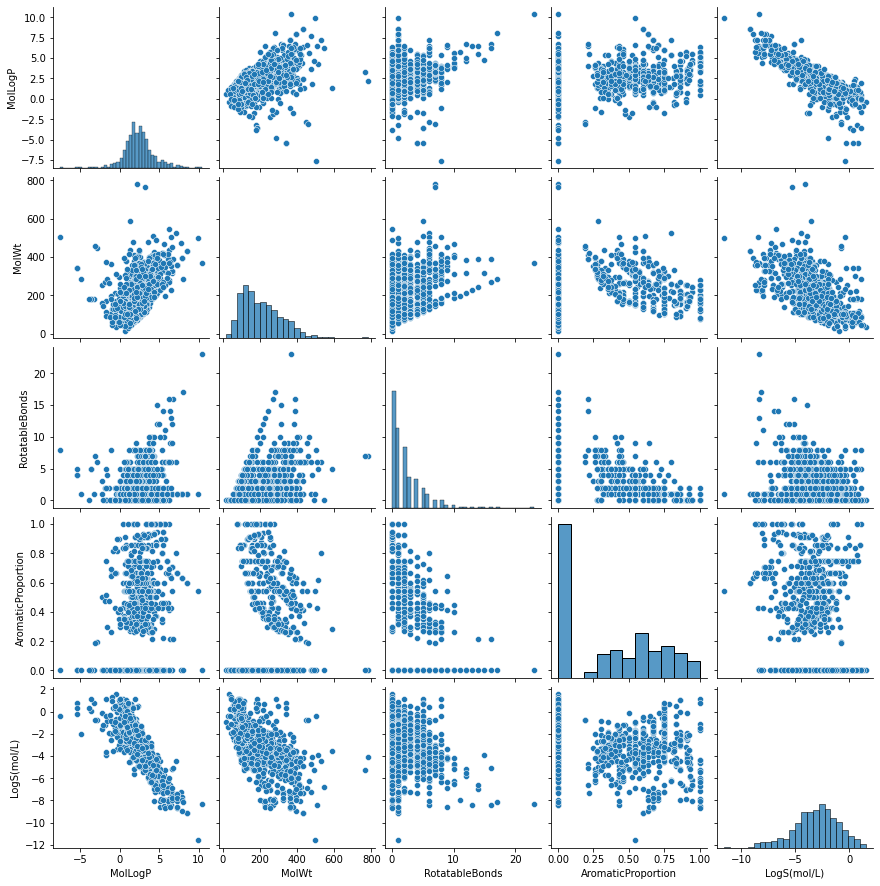

In [147]:
# Looking for correlation 
import seaborn as sns
sns.pairplot(newdataset)

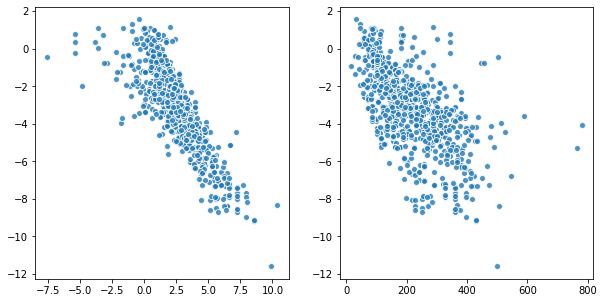

In [148]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(newdataset["MolLogP"], newdataset["LogS(mol/L)"], alpha = 0.8, edgecolor = "white")
plt.subplot(1,2,2)
plt.scatter(newdataset["MolWt"], newdataset["LogS(mol/L)"], alpha = 0.8, edgecolor = "white")
plt.show()

After looking at the scatter plots and the correlation charts, that both MolLogP and MolWt (Partition coefficient and Molecular weight) are inversely correlated with the Solubility of the molecule.

##**Building the Linear Model**

In [149]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [150]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

In [151]:
Y_pred_train = regr.predict(X_train)

In [152]:
Y_pred_train[:10] # The first 10 values predicted by the model

array([-4.47026156, -5.88839323, -4.22029229, -0.79352323, -1.73062942,
       -1.26187649, -1.43969557, -2.36087206, -2.77481055, -2.23755209])

In [153]:
Y_train.head(10) # The actual first 10 valus from the train set

643    -4.300
722    -8.400
570    -3.754
66      0.000
1002   -1.340
67     -1.940
319    -0.800
442    -2.320
12     -3.200
1105   -2.210
Name: measured log(solubility:mol/L), dtype: float64

##**Model Evaluation**

The Evaluation metrics is important for evaluating the performance of a  model. It aims to estimate the generalization accuracy of a model on the future data.
Here the evaluation metrics are :

*   Mean Absolute Error
*   Mean Squared Error
*   R2 Score 


In [154]:
print("Coefficient values : " ,regr.coef_)
print("Intercept value : ", regr.intercept_)
print("Mean squared error (MSE): %.2f"% mean_squared_error(Y_train, Y_pred_train))
print("Coefficient of determination (R^2): %.2f"% r2_score(Y_train, Y_pred_train))
print("Mean absolute Error : %.2f"%mean_absolute_error(Y_train, Y_pred_train))

Coefficient values :  [-0.72521491 -0.00663091  0.00502635 -0.50455953]
Intercept value :  0.2527241796315507
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77
Mean absolute Error : 0.76


## **Performance on the test set**

using the model to predict the values of the test set and then evaluating the results :

In [155]:
Y_pred_test = regr.predict(X_test)

In [156]:
Y_pred_test[:10] # The first 10 values predicted by the model

array([-1.53917269, -6.08287944, -5.28375883, -3.27746087, -1.70320929,
       -5.63167711, -1.43239582, -2.74544339, -3.43274443, -3.79048137])

In [157]:
Y_test.head(10) # The actual first 10 valus from the test set

218    -0.890
809    -6.890
501    -4.530
649    -3.420
323    -0.466
506    -5.670
1005    0.020
107    -4.440
731    -3.090
170    -2.340
Name: measured log(solubility:mol/L), dtype: float64

In [158]:
print("Mean squared error (MSE): %.2f"% mean_squared_error(Y_test, Y_pred_test))
print("Coefficient of determination (R^2): %.2f"% r2_score(Y_test, Y_pred_test))
print("Mean absolute Error : %.2f"%mean_absolute_error(Y_test, Y_pred_test))

Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.77
Mean absolute Error : 0.80


## **Linear Regression Equation**

In [159]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (regr.intercept_, regr.coef_[0], regr.coef_[1], regr.coef_[2], regr.coef_[3] ) )

LogS = 0.25 -0.73 LogP -0.0066 MW 0.0050 RB -0.50 AP


The work of Delaney provided the following linear regression equation:

> LogS = **0.16 -  0.63** cLogP  **- 0.0062** MW **+ 0.066** RB **- 0.74** AP

The reproduction by Pat Walters  provided the following:

> LogS = **0.26 - 0.74** LogP **- 0.0066** MW + **0.0034** RB **- 0.42** AP


 Our reproduction of the project gave the following equation :

 > LogS = **0.25** **- 0.73** LogP **- 0.0066** MW **+ 0.0050** RB **- 0.50** AP

##**Scatter plot of experimental vs. predicted LogS**:

In [160]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

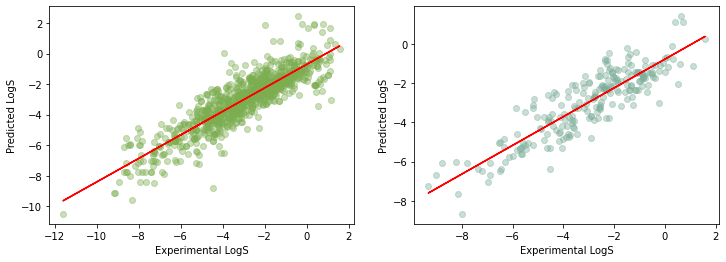

In [161]:
plt.figure(figsize=(12,4))

# plot 1 (Y train vs Y train predicted)
plt.subplot(1,2,1)

plt.scatter(Y_train, Y_pred_train, c="#7CAE50", alpha=0.4)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_train,p(Y_train),"-r")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')


# plot 2 (Y test vs Y test predicted)
plt.subplot(1,2,2)

plt.scatter(Y_test, Y_pred_test, c="#7CAE99", alpha=0.4)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"r")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.show()

## **Using the entire dataset for model training**

Since the total number of datapoints are low, the more datapoints that are used for training the model, the better it performs. Also, Delaney as well as Pat Walters used the complete dataset for arriving at the above result. So, for comparision, we too use the entire dataset for model building, and compare the results.

In [162]:
full = linear_model.LinearRegression()
full.fit(X, Y)
full_pred = full.predict(X)

In [163]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [164]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (full.intercept_, full.coef_[0], full.coef_[1], full.coef_[2], full.coef_[3] ) )

LogS = 0.26 -0.74 LogP -0.0066 MW 0.0032 RB -0.42 AP


Equation from Delany :

> LogS = **0.16 -  0.63** cLogP  **- 0.0062** MW **+ 0.066** RB **- 0.74** AP

The reproduction by Pat Walters  provided the following:

> LogS = **0.26 - 0.74** LogP **- 0.0066** MW + **0.0034** RB **- 0.42** AP

 Equation using train dataset :

 > LogS = **0.25** **- 0.73** LogP **- 0.0066** MW **+ 0.0050** RB **- 0.50** AP

 Equation using the entire dataset :

 > LogS = **0.26** **- 0.74** LogP **- 0.0066** MW **+ 0.0032** RB **- 0.42** AP

So, by using the entire dataset, we have built a model that comes close to replicating the work done by Pat Walters  

### Pickling the Linear model

In [165]:
import pickle
pickle.dump(regr, open('solubility_model.pkl','wb'))

## **References**

1. John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). ***J. Chem. Inf. Comput. Sci.*** 2004, 44, 3, 1000-1005.

2. Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). ***Practical Cheminformatics Blog***

3. [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x) from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.